# Customer Churn - Empresa de Telecomunicações

O termo **Customer Churn** refere-se a decisão tomada pelo cliente pelo término do relacionamento comercial com uma empresa.

**Objetivo:** prever a probabilidade de usuários abandonarem o relacionamento comercial com a empresa de Telecomunicações.

**Técnicas abordadas:** Transformação de valores categóricos, Criação de novos atributos, Remoção de atributos colineares, Oversampling, Cross-validation

**Algoritmos de classificação utilizados:** Regressão Logística, RandomForest e XGBoost

**Método de avaliação da precisão:** accuracy_score e roc_auc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

/Users/brunomaciel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Histogramas das variáveis dividido por classe
def compare_target_hist(dataframe, att_target, target1='yes', target0='no', figsize=(15,9), subplot_rows=3, subplot_cols=3, n_bins=20):
    df_targetPositive = dataframe[dataframe[att_target] == target1]
    df_targetNegative = dataframe[dataframe[att_target] == target0]

    plt.figure(figsize=figsize)
    i = 1
    for col in dataframe.columns:
        plt.subplot(subplot_rows, subplot_cols, i)
        plt.hist(df_targetPositive[col], bins=n_bins, edgecolor='black', label='Yes')
        plt.hist(df_targetNegative[col], bins=n_bins, edgecolor='orange', fill=False, hatch='/', 
                 linewidth=1.2, label='No')
        plt.title(col)
        plt.grid()
        plt.legend()
        i += 1
    plt.tight_layout()
    plt.show()

# Heatmap com correlações entre as variáveis
def plot_correlation_heatmap(dataframe, figsize=(18, 5)):
    # Correlação entre variáveis
    plt.figure(figsize=figsize)
    sns.heatmap(dataframe.corr(), cmap='coolwarm', annot=True, fmt='.3f', vmin=-1, vmax=1)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, labeltop=True,
                    bottom=False, top=False, left=False)
    plt.xticks(rotation=30)
    plt.show()

# Diferença entre a quantidade de registros de cada classe
def show_target_distribution(dataframe, att_target):
    target_values = dataframe[att_target].value_counts()
    for target, amount in zip(target_values.index, target_values.values):
        print('Classe {}: {:5d} ({:.2f}%)'.format(target, amount, amount/df5.shape[0]*100))

    dataframe[att_target].value_counts().plot(kind='bar')
    plt.show()

# Boxplot comparando os resultados para cada modelo
def compare_result_distribution(dataframe, title=None, show_statistics=True, figsize=(7, 5)):
    plt.figure(figsize=figsize)
    sns.boxplot(data=dataframe, orient='h', showfliers=True)
    plt.title('Comparação Resultados' if title is None else title)
    plt.xlabel('score')
    plt.show()
    
    if show_statistics:
        df_stats = dataframe.describe().loc[['mean', 'min', 'max', 'std']]
        print(df_stats)

# Plot da ROC Curve
def plot_roc_curve(real_value, previsoes, roc_score=None, figsize=(10, 5)):
    false_positive_rate, true_positive_rate, _ = roc_curve(real_value, previsoes)
    if roc_score is None:
        roc_score = roc_auc_score(real_value, previsoes)
    
    plt.figure(figsize=figsize)
    plt.plot([0, 0, 1], [0, 1, 1], color='gray', linestyle='--', linewidth=0.7)
    plt.plot([0, 1], [0,1], color='#880000', linestyle='--', linewidth=0.7)
    plt.plot(false_positive_rate, true_positive_rate, label='{:.4f}'.format(roc_score))
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.show()

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('data/telecom_treino.csv', index_col=0)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [5]:
df.shape

(3333, 20)

## 1. Exploração dos Dados

In [6]:
print('Dados faltantes:', df.shape[0]-df.dropna().shape[0])
print('Dados duplicados:', df.shape[0]-df.drop_duplicates().shape[0])

Dados faltantes: 0
Dados duplicados: 0


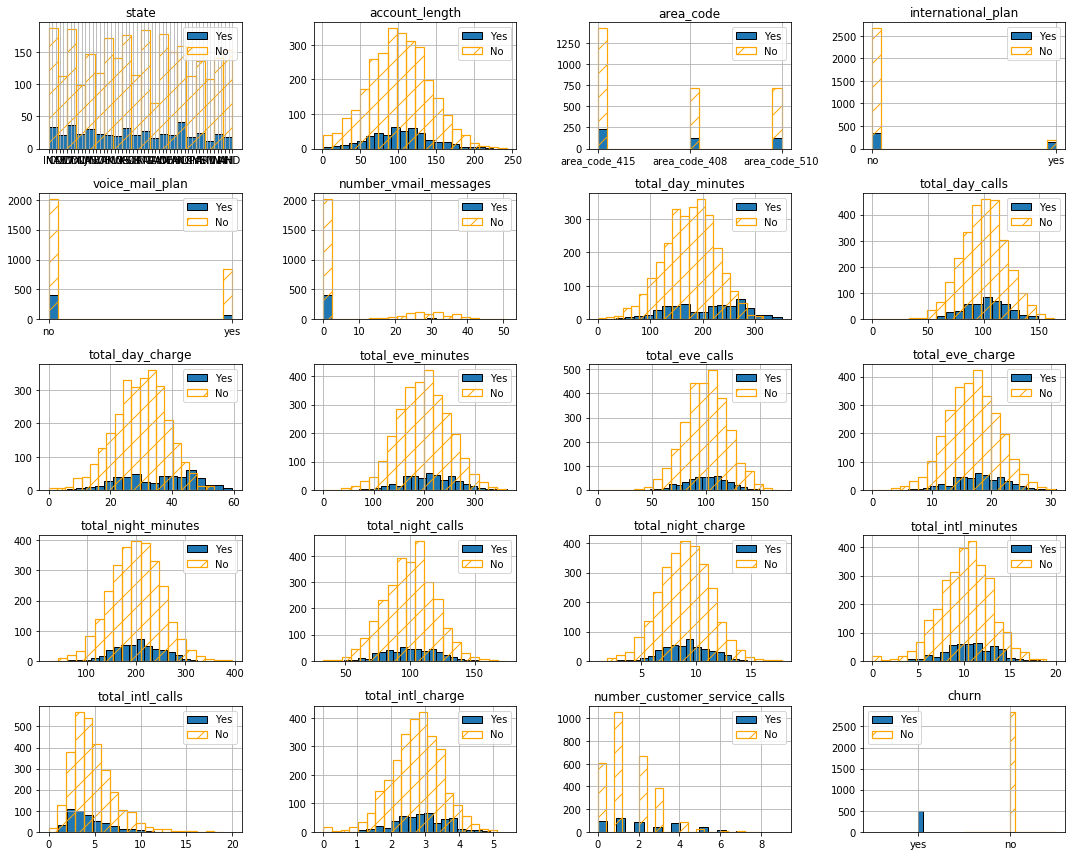

In [7]:
# Praticamente metade das pessoas que tem um international_plan deixam a companhia.
# Possivelmente o plano não é satisfatório. Uma análise mais detalhada é indicada
compare_target_hist(df, att_target='churn', subplot_cols=4, subplot_rows=5, figsize=(15, 12))

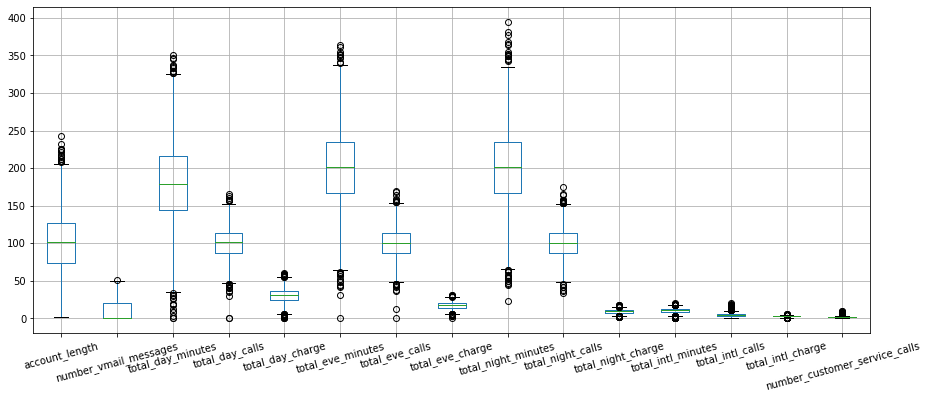

In [8]:
df.boxplot(figsize=(15, 6))
plt.xticks(rotation=15)
plt.show()

<br/> 
## 2. Limpeza e Transformação nos Dados

In [9]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


#### a) Transformação de valores categóricos em numéricos

In [10]:
def labelEncoder(dataframe):
    df = dataframe.copy()
    
    df['international_plan'].replace('no', 0, inplace=True)
    df['international_plan'].replace('yes', 1, inplace=True)
    df['voice_mail_plan'].replace('no', 0, inplace=True)
    df['voice_mail_plan'].replace('yes', 1, inplace=True)
    df['churn'].replace('no', 0, inplace=True)
    df['churn'].replace('yes', 1, inplace=True)
    
    df['area_code'] = df['area_code'].map(lambda value: int(value[-3:]))
    
    return df

In [11]:
df2 = labelEncoder(df)
df2.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
2,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
3,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
4,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
5,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


#### b) Valores Faltantes (zero)
Variáveis *total_day_minutes*, *total_day_calls*, *total_day_charge*, *total_eve_minutes*, *total_eve_calls* e *total_eve_charge* apresentam valores 0 que indicam valores faltantes.

Substituição dos valores faltantes pela mediana.

In [14]:
df2.describe()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


In [13]:
df2.query("total_day_minutes == 0 | total_day_calls == 0 | total_day_charge == 0 | \
           total_eve_minutes == 0 | total_eve_calls == 0 | total_eve_charge == 0")

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1346,SD,98,415,0,0,0,0.0,0,0.00,159.6,130,13.57,167.1,88,7.52,6.8,1,1.84,4,1
1398,VT,101,510,0,0,0,0.0,0,0.00,192.1,119,16.33,168.8,95,7.60,7.2,4,1.94,1,0
2933,UT,97,415,0,0,0,209.2,134,35.56,0.0,0,0.00,175.4,94,7.89,11.8,6,3.19,1,0


In [15]:
def replace_missing_by_median(dataframe, cols):
    df = dataframe.copy()
    
    for col in cols:
        avg_col = df[col][df[col] > 0].median()
        df[col].replace(0, avg_col, inplace=True)

    return df

In [16]:
# As variáveis 'total_day_minutes' e 'total_eve_minutes' não serão tratadas no momento, 
# pois serão excluídas posteriormente
df3 = replace_missing_by_median(df2, cols=['total_day_calls', 'total_day_charge', 
                                           'total_eve_calls', 'total_eve_charge'])

## 3. Feature Engineering

#### a) Criação de Atributos

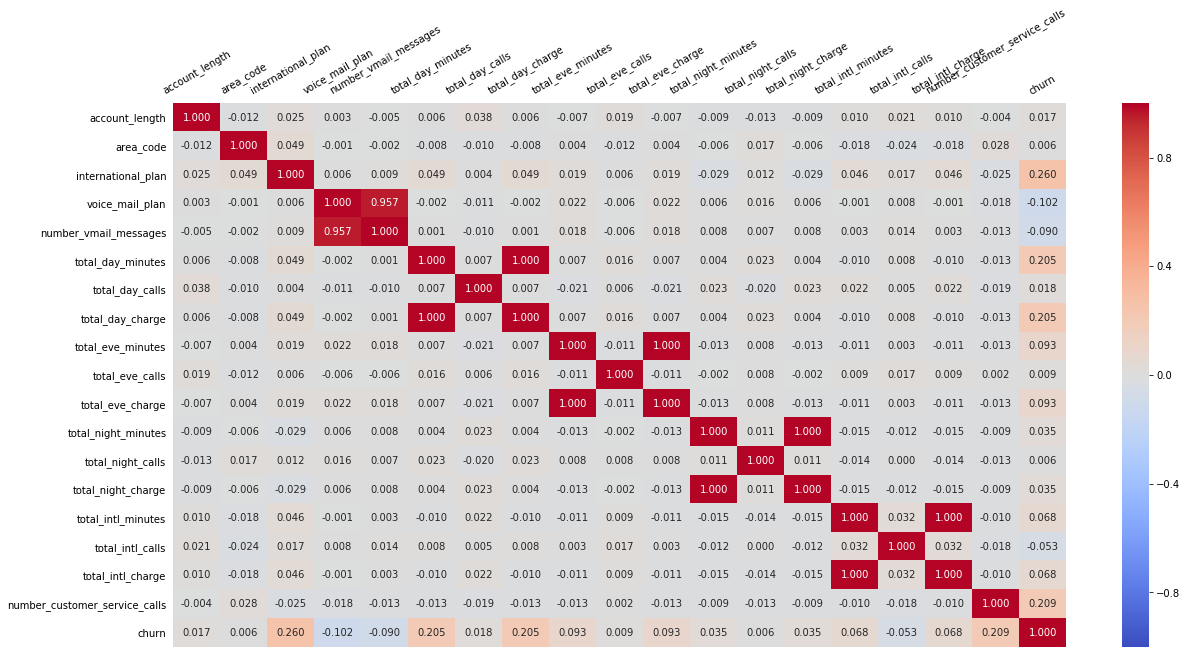

In [17]:
plot_correlation_heatmap(df2, figsize=(20, 10))

In [18]:
def create_new_features(dataframe):
    df = dataframe.copy()
    
    df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + \
                          df['total_intl_minutes']
    df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + \
                         df['total_intl_charge']
    
    return df

In [19]:
# Cria atributos de Tempo Total de Chamadas e Custo Total de Chamadas
df4 = create_new_features(df3)

#### b) Remoção de Atributos Colineares

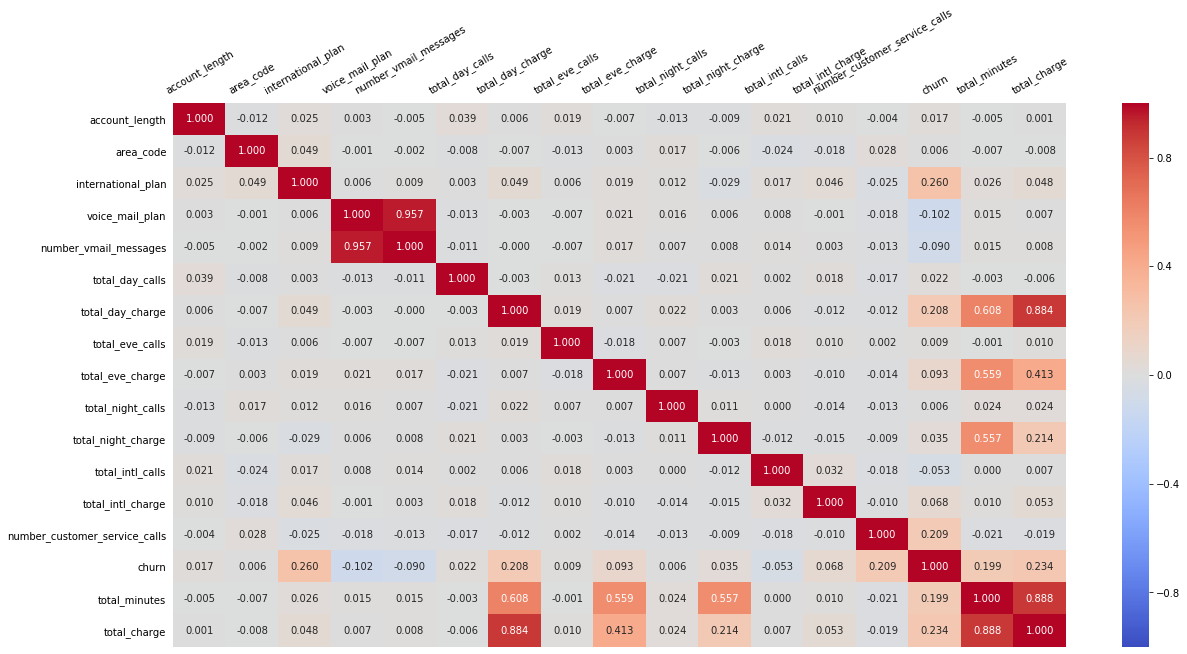

In [20]:
# Atributos apresentaram correlação = 1.0 com outros atributos
df5 = df4.drop(columns=['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes'])
plot_correlation_heatmap(df5, figsize=(20, 10))

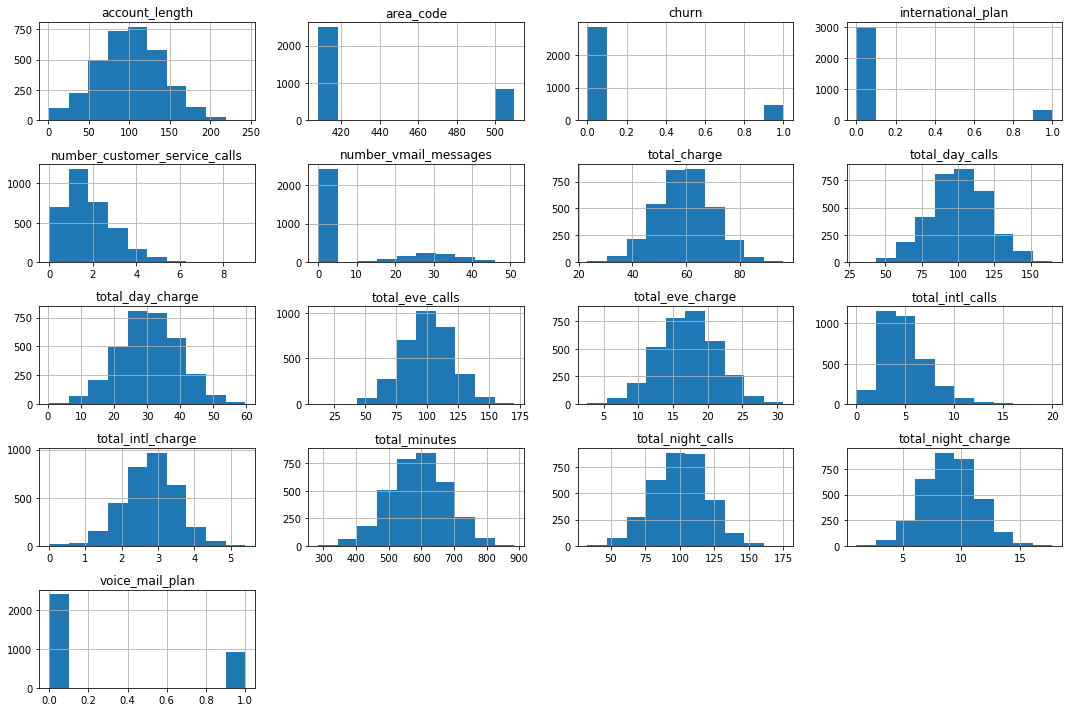

In [21]:
df5.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

#### c) OneHot Encoder

In [22]:
def onehotencoder(dataframe, cols):
    df = dataframe.copy()
    for col in cols:
        unique_values = np.sort(df[col].unique())
        for value in unique_values:
            new_col = col + '_' + str(value)
            df[new_col] = (df[col] == value).astype(int)

    df.drop(columns=cols, inplace=True)
    return df

In [23]:
df6 = onehotencoder(df5, cols=['area_code'])

#### d) Exclusão da Coluna *State*
Por testes, a coluna *state* não apresentou contribuição para melhoria da precisão do modelo

In [24]:
df7 = df6.drop(columns='state')
df7.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_calls,total_night_charge,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,total_minutes,total_charge,area_code_408,area_code_415,area_code_510
1,128,0,1,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0,717.2,75.56,0,1,0
2,107,0,1,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0,625.2,59.24,0,1,0
3,137,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0,539.4,62.29,0,1,0
4,84,1,0,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0,564.8,66.80,1,0,0
5,75,1,0,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0,512.0,52.09,0,1,0


<br/> 
## 4. Oversampling

#### SMOTE

Classe 0:  2850 (85.51%)
Classe 1:   483 (14.49%)


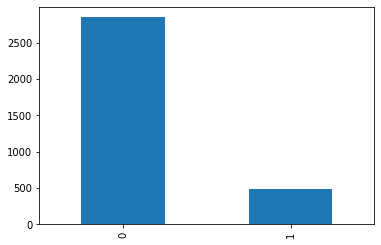

In [25]:
show_target_distribution(df7, att_target='churn')

In [26]:
df_aux = df7.copy()

features = df_aux.drop(columns='churn')
target = df_aux['churn'].values

smote = SMOTE(sampling_strategy='minority', random_state=10)
x_over, y_over = smote.fit_sample(features.values, target)

df_oversampled = pd.DataFrame(x_over, columns=features.columns)
df_oversampled['churn'] = y_over

df_oversampled.churn.value_counts()

1    2850
0    2850
Name: churn, dtype: int64

<br/> 
## 5. Machine Learning

In [27]:
# Pre processamento
x = df_oversampled.drop(columns='churn').values
y = df_oversampled['churn'].values

scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(x)

Logistic Regression...
Random Forest...
XGBoost...


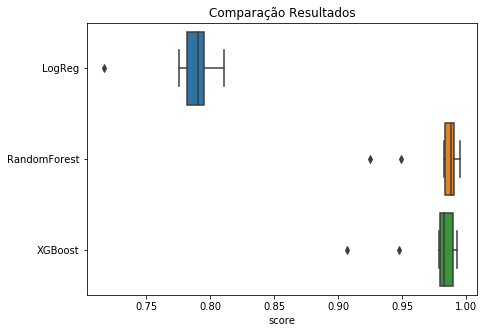

        LogReg  RandomForest   XGBoost
mean  0.783860      0.978421  0.974035
min   0.717544      0.924561  0.907018
max   0.810526      0.994737  0.992982
std   0.025286      0.022935  0.026860


In [28]:
print('Logistic Regression...')
model_log = LogisticRegression()
score_log = cross_val_score(model_log, x_scaled, y, scoring='accuracy', cv=10)

print('Random Forest...')
model_forest = RandomForestClassifier(n_estimators=100, random_state=10)
score_forest = cross_val_score(model_forest, x_scaled, y, scoring='accuracy', cv=10)

print('XGBoost...')
model_xgb = XGBClassifier(n_estimators=100)
score_xgb = cross_val_score(model_xgb, x_scaled, y, scoring='accuracy', cv=10)


scores_df = pd.DataFrame([score_log, score_forest, score_xgb]).T
scores_df.columns=['LogReg', 'RandomForest', 'XGBoost']

compare_result_distribution(scores_df)

## 6. Tuning de Parâmetros
Teste com os hyperparâmetros:
 - *n_estimators*
 - *max_depth*
 - *min_samples_leaf*
 - *max_features*

In [ ]:
n_tree_list = [180, 190, 200, 210]
max_depth_list = [10, 12, 15]
min_leaf_list = [1, 2]
max_features_list = ['sqrt', 'log2']

best_score = 0
n_test = 0
n_total_test = len(n_tree_list)*len(max_depth_list)*len(min_leaf_list)*len(max_features_list)
for n_tree in n_tree_list:
    for depth in max_depth_list:
        for min_leaf in min_leaf_list:
            for max_feat in max_features_list:
                n_test += 1
                print('Teste {:2d}/{}'.format(n_test, n_total_test))
                
                model = RandomForestClassifier(n_estimators=n_tree, max_depth=depth, 
                                               min_samples_leaf=min_leaf, max_features=max_feat, 
                                               random_state=10)
                score = cross_val_score(model, x_scaled, y, cv=10, scoring='roc_auc')
                
                if score.mean() > best_score:
                    best_score = score.mean()
                    best_param = {'n_estimators' : n_tree, 'max_depth' : depth,
                                  'min_samples_leaf' : min_leaf, 'max_features' : max_feat}
                    print("  Trees: {:3d} | Depth: {:2d} | Leaf: {} | MaxFeat: {}".format(n_tree, depth, min_leaf, max_feat))
                    print('  best score: {:.5f}'.format(best_score))
print('Best Params:', best_param)

<br/><br/> 
## Modelo Final

In [29]:
# Pre Processamento
x = df_oversampled.drop(columns='churn').values
y = df_oversampled['churn'].values

scaler_final_x = StandardScaler()
x_scaled = scaler_final_x.fit_transform(x)

# Seleção dados de Treino
x_train, _, y_train, _ = train_test_split(x_scaled, y, train_size=0.95, random_state=10)

# Machine Learning
model_final = RandomForestClassifier(n_estimators=190, max_depth=15, min_samples_leaf=1, 
                                     max_features='sqrt', random_state=10)
model_final.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=190,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

<br/><br/>
## Validação do Modelo

In [30]:
data_validation = pd.read_csv('data/telecom_teste.csv', index_col=0)
data_validation.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,HI,101,area_code_510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
2,MT,137,area_code_510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
3,OH,103,area_code_408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
4,NM,99,area_code_415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
5,SC,108,area_code_415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


In [31]:
data_validation.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000,1667.000000
mean,98.646671,7.067786,181.316197,99.217157,30.824337,199.949190,100.344331,16.995903,199.431074,99.542292,8.974559,10.310738,4.346731,2.784421,1.585483
std,39.400755,13.235274,52.732174,19.327148,8.964421,50.232869,19.637935,4.269758,50.437010,20.717441,2.269604,2.699660,2.446252,0.728764,1.288179
min,1.000000,0.000000,6.600000,34.000000,1.120000,22.300000,38.000000,1.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.000000,0.000000,143.750000,86.000000,24.440000,165.900000,88.000000,14.100000,166.600000,86.000000,7.500000,8.600000,3.000000,2.320000,1.000000
50%,98.000000,0.000000,181.000000,99.000000,30.770000,200.400000,100.000000,17.030000,199.400000,99.000000,8.970000,10.400000,4.000000,2.810000,1.000000
75%,126.000000,0.000000,215.750000,112.000000,36.680000,232.300000,113.000000,19.745000,233.050000,113.000000,10.490000,12.000000,5.000000,3.240000,2.000000
max,238.000000,52.000000,351.500000,160.000000,59.760000,359.300000,169.000000,30.540000,381.600000,170.000000,17.170000,19.700000,19.000000,5.320000,7.000000


#### Transformação nos Dados

In [32]:
# Substitui valores faltantes (zero) dos atributos 'total_night_calls' e 'total_night_charge' pela mediana
data2 = data_validation.copy()

for col in ['total_night_calls', 'total_night_charge']:
    avg_col = df7[col].median()
    data2[col].replace(0, avg_col, inplace=True)

In [33]:
# Processos de Transformação de variaveis categóricas, Criação de novas variaveis e Onehotencoder
data3 = labelEncoder(data2)
data4 = create_new_features(data3)
data5 = onehotencoder(data4, cols=['area_code'])

In [34]:
# Exclui todas as colunas que não estão no dataset utilizado para treinamento
# e confere se as colunas estão com o mesmo nome e na mesma ordem
cols_to_drop = [col for col in data5.columns if col not in df7.columns]
data6 = data5.drop(columns=cols_to_drop)
print('Colunas na ordem correta:', (data6.columns == df7.columns).all())

Colunas na ordem correta: True


#### Previsões

In [35]:
# Machine Learning
x = data6.drop(columns='churn').values
y = data6['churn'].values

x_scaled = scaler_final_x.transform(x)

previsoes = model_final.predict_proba(x_scaled)
previsoes = previsoes[:, 1]
prev_round = np.round(previsoes, 0)

#### Avaliação

Accuracy: 0.9814
ROC AUC:  0.9249
ConfMat:
 [[1443    0]
 [  31  193]]


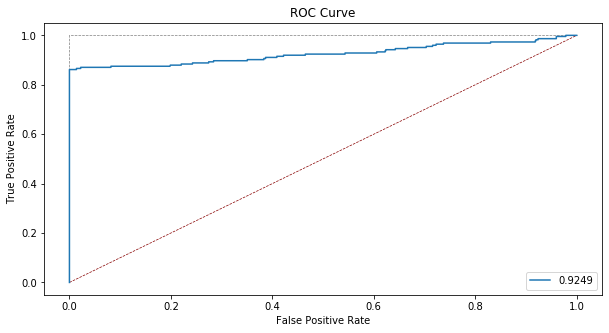

In [36]:
print('Accuracy: {:.4f}'.format(accuracy_score(y, prev_round)))
print('ROC AUC:  {:.4f}'.format(roc_auc_score(y, previsoes)))
print('ConfMat:\n', confusion_matrix(y, prev_round))

plot_roc_curve(y, previsoes)

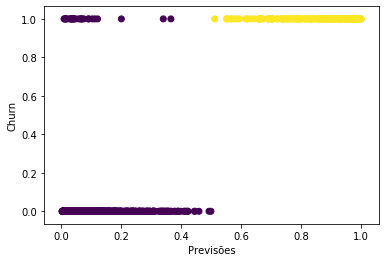

In [37]:
# Visualização gráfica das previsões comparado a classe real
df_previsoes = data6.copy()
df_previsoes['previsoes'] = previsoes

plt.scatter(df_previsoes['previsoes'], df_previsoes['churn'], 
            c=np.round(df_previsoes['previsoes'], 0))
plt.ylabel('Churn')
plt.xlabel('Previsões')
plt.show()